ResNet-152 Inner Workings Analysis
Device: cuda
Random seed: 42

TASK 1: Baseline Setup - Fine-tuning on CIFAR-10


100%|██████████| 170M/170M [00:18<00:00, 9.17MB/s]


CIFAR-10: 50000 train, 10000 test
Loading pretrained ResNet-152...
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


100%|██████████| 230M/230M [00:01<00:00, 202MB/s]


Trainable parameters: 20,490

Training Baseline ResNet-152...
----------------------------------------------------------------------
Epoch 1/3: Train Loss: 0.6693, Val Loss: 0.5025, Val Acc: 82.80%
Epoch 2/3: Train Loss: 0.5130, Val Loss: 0.4878, Val Acc: 83.13%
Epoch 3/3: Train Loss: 0.4927, Val Loss: 0.4869, Val Acc: 83.47%
----------------------------------------------------------------------

TASK 2: Residual Connections in Practice
Loading pretrained ResNet-152...

Disabling skip connections in: ['layer4.0', 'layer4.1']
Trainable parameters: 20,490

Training No-Skip ResNet-152...
----------------------------------------------------------------------
Epoch 1/3: Train Loss: 0.8678, Val Loss: 0.7035, Val Acc: 76.75%
Epoch 2/3: Train Loss: 0.6984, Val Loss: 0.6534, Val Acc: 78.35%
Epoch 3/3: Train Loss: 0.6609, Val Loss: 0.6666, Val Acc: 77.59%
----------------------------------------------------------------------

Comparison: Baseline vs No-Skip Connections
--------------------------

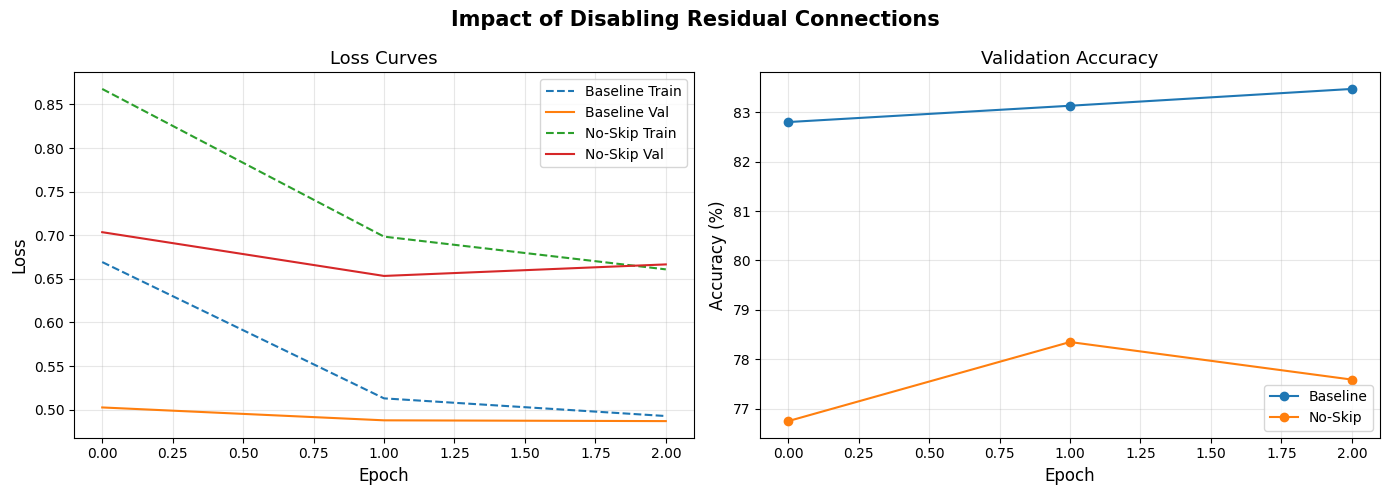


TASK 3: Feature Hierarchies and Representations

Extracting features from ['layer1', 'layer3', 'layer4']...
Features extracted:
  layer1: shape torch.Size([1000, 802816])
  layer3: shape torch.Size([1000, 200704])
  layer4: shape torch.Size([1000, 100352])

Generating UMAP visualizations...
  Processing layer1...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


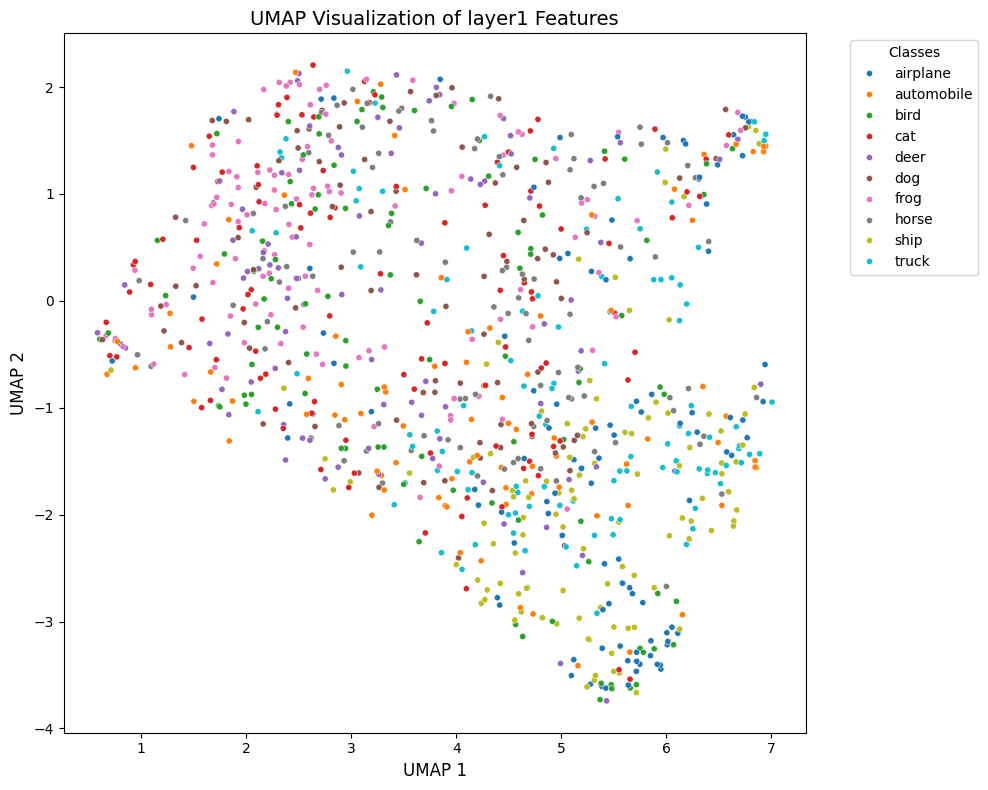

  Processing layer3...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


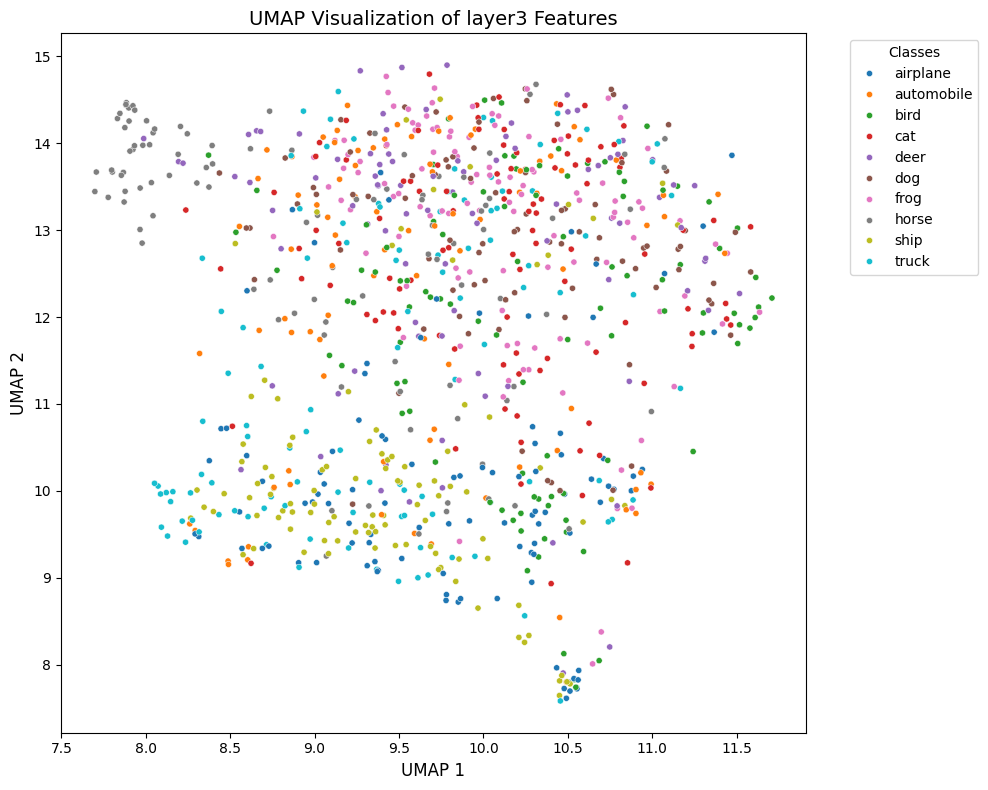

  Processing layer4...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


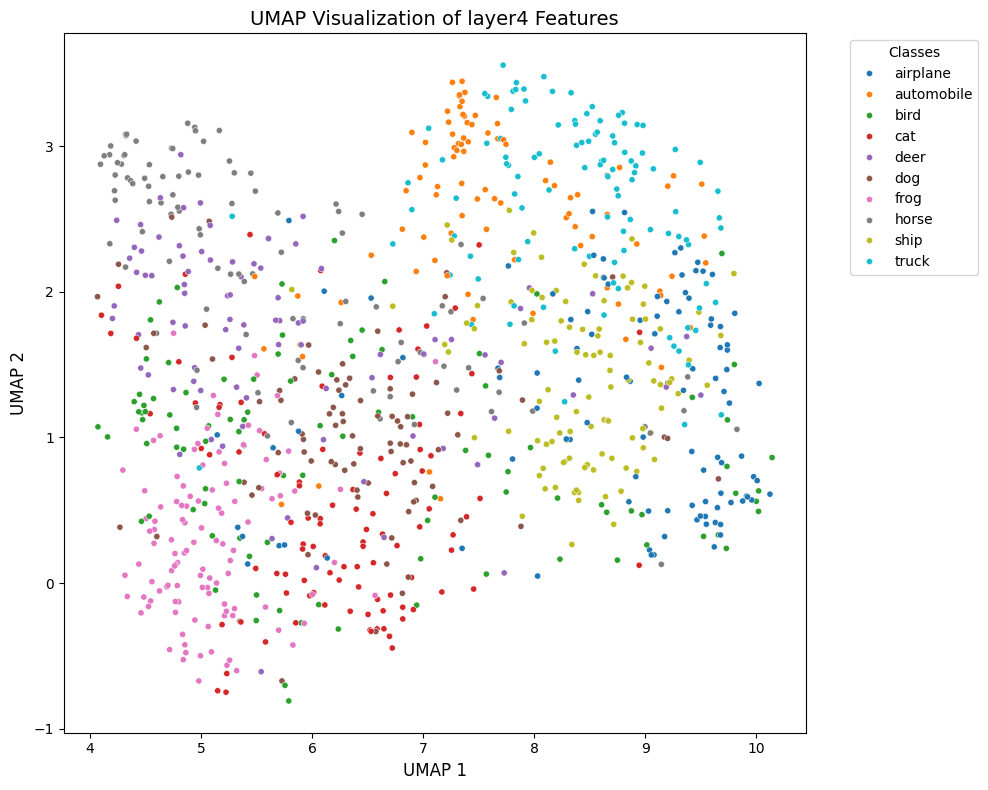


TASK 4: Transfer Learning and Generalization


100%|██████████| 169M/169M [00:16<00:00, 10.5MB/s]


CIFAR-100: 50000 train, 10000 test

[4a] Pretrained model with frozen backbone (head-only fine-tuning)
Loading pretrained ResNet-152...
Trainable parameters: 204,900

Training Pretrained (Head-Only)...
----------------------------------------------------------------------
Epoch 1/3: Train Loss: 1.9275, Val Loss: 1.4777, Val Acc: 58.14%
Epoch 2/3: Train Loss: 1.3535, Val Loss: 1.3604, Val Acc: 62.37%
Epoch 3/3: Train Loss: 1.2468, Val Loss: 1.3433, Val Acc: 62.56%
----------------------------------------------------------------------

[4b] Random initialization with frozen backbone (head-only training)
Initializing ResNet-152 with random weights...
Trainable parameters: 204,900

Training Random Init (Head-Only)...
----------------------------------------------------------------------
Epoch 1/3: Train Loss: 5.0262, Val Loss: 5.1234, Val Acc: 2.35%
Epoch 2/3: Train Loss: 4.9400, Val Loss: 5.9033, Val Acc: 1.24%
Epoch 3/3: Train Loss: 4.8958, Val Loss: 4.9841, Val Acc: 3.16%
--------------

In [ ]:
"""
ResNet-152 Inner Workings Analysis
This script explores ResNet-152 architecture through:
1. Baseline fine-tuning on CIFAR-10
2. Residual connection ablation studies
3. Feature hierarchy visualization with UMAP
4. Transfer learning experiments on CIFAR-100
"""

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import types


# ============================================================================
# Configuration
# ============================================================================

class Config:
    """Configuration parameters for ResNet-152 analysis"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    random_seed = 42

    # Training parameters
    batch_size = 64
    learning_rate = 0.001
    epochs_cifar10 = 3
    epochs_cifar100 = 3

    # Fine-tuning parameters
    lr_block_finetune = 0.0001
    lr_full_finetune = 0.00001

    # Visualization parameters
    umap_n_components = 2
    umap_random_state = 42
    n_samples_visualization = 1000

    # CIFAR-10 classes
    cifar10_classes = [
        'airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck'
    ]


# ============================================================================
# Data Loading
# ============================================================================

def get_transforms():
    """Get standard ImageNet transforms for ResNet"""
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])


def load_cifar10(batch_size=64):
    """Load CIFAR-10 dataset"""
    transform = get_transforms()

    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform
    )
    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(f"CIFAR-10: {len(train_dataset)} train, {len(test_dataset)} test")
    return train_loader, test_loader


def load_cifar100(batch_size=64):
    """Load CIFAR-100 dataset"""
    transform = get_transforms()

    train_dataset = torchvision.datasets.CIFAR100(
        root='./data', train=True, download=True, transform=transform
    )
    test_dataset = torchvision.datasets.CIFAR100(
        root='./data', train=False, download=True, transform=transform
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(f"CIFAR-100: {len(train_dataset)} train, {len(test_dataset)} test")
    return train_loader, test_loader


# ============================================================================
# Model Setup
# ============================================================================

def setup_resnet152(num_classes=10, pretrained=True, device='cpu'):
    """
    Setup ResNet-152 with custom head

    Args:
        num_classes: Number of output classes
        pretrained: Whether to use pretrained weights
        device: Device to load model on

    Returns:
        model: ResNet-152 model
    """
    if pretrained:
        weights = 'IMAGENET1K_V1'
        print("Loading pretrained ResNet-152...")
    else:
        weights = None
        print("Initializing ResNet-152 with random weights...")

    model = torchvision.models.resnet152(weights=weights).to(device)

    # Replace classification head
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes).to(device)

    return model


def freeze_backbone(model, unfreeze_layers=None):
    """
    Freeze model backbone, optionally unfreezing specific layers

    Args:
        model: PyTorch model
        unfreeze_layers: List of layer names to unfreeze (e.g., ['layer4', 'fc'])
    """
    # Freeze all parameters
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze specified layers
    if unfreeze_layers is None:
        unfreeze_layers = ['fc']

    for layer_name in unfreeze_layers:
        layer = getattr(model, layer_name)
        for param in layer.parameters():
            param.requires_grad = True

    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable parameters: {trainable_params:,}")

    return model


# ============================================================================
# Modified ResNet (No Skip Connections)
# ============================================================================

class ModifiedResNet(nn.Module):
    """ResNet with disabled skip connections in specified blocks"""

    def __init__(self, original_model, disable_blocks):
        """
        Args:
            original_model: Original ResNet model
            disable_blocks: List of block names to disable (e.g., ['layer4.0', 'layer4.1'])
        """
        super().__init__()
        self.model = original_model
        self.disable_blocks = disable_blocks
        self.original_forwards = {}

        # Modify forward passes to skip residual connections
        for block_name in disable_blocks:
            block = self._get_block(block_name)
            self.original_forwards[block_name] = block.forward
            block.forward = types.MethodType(self._no_skip_forward, block)

    def _get_block(self, block_name):
        """Get block by name (e.g., 'layer4.0')"""
        block = self.model
        for part in block_name.split('.'):
            block = getattr(block, part)
        return block

    @staticmethod
    def _no_skip_forward(self_block, x):
        """Forward pass without residual connection"""
        out = self_block.conv1(x)
        out = self_block.bn1(out)
        out = self_block.relu(out)

        out = self_block.conv2(out)
        out = self_block.bn2(out)

        if hasattr(self_block, 'conv3'):
            out = self_block.conv3(out)
            out = self_block.bn3(out)

        # Note: No addition with identity/skip connection
        return self_block.relu(out)

    def forward(self, x):
        return self.model(x)


# ============================================================================
# Training Functions
# ============================================================================

def train_epoch(model, train_loader, optimizer, criterion, device='cpu'):
    """Train for one epoch"""
    model.train()
    total_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)


def validate_epoch(model, test_loader, criterion, device='cpu'):
    """Validate for one epoch"""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy


def train_model(model, train_loader, test_loader, optimizer, criterion,
                epochs=3, device='cpu', model_name="Model"):
    """
    Complete training loop

    Returns:
        history: Dictionary with training history
    """
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': []
    }

    print(f"\nTraining {model_name}...")
    print("-" * 70)

    for epoch in range(epochs):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate_epoch(model, test_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss: {train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Acc: {val_acc:.2f}%")

    print("-" * 70)
    return history


# ============================================================================
# Feature Extraction and Visualization
# ============================================================================

def extract_layer_features(model, data_loader, layer_names, max_samples=1000, device='cpu'):
    """
    Extract features from specified layers

    Args:
        model: PyTorch model
        data_loader: DataLoader for data
        layer_names: List of layer names to extract features from
        max_samples: Maximum number of samples to extract
        device: Device to run on

    Returns:
        all_features: Dictionary of features per layer
        all_labels: Labels for samples
    """
    features = {}

    # Register hooks
    def get_features(name):
        def hook(module, input, output):
            features[name] = output.detach()
        return hook

    hooks = []
    for layer_name in layer_names:
        layer = getattr(model, layer_name)
        hook = layer.register_forward_hook(get_features(layer_name))
        hooks.append(hook)

    # Extract features
    model.eval()
    all_features = {name: [] for name in layer_names}
    all_labels = []
    sample_count = 0

    print(f"\nExtracting features from {layer_names}...")

    with torch.no_grad():
        for images, labels in data_loader:
            if sample_count >= max_samples:
                break

            images = images.to(device)
            _ = model(images)

            for layer_name in layer_names:
                layer_feats = features[layer_name].cpu().view(features[layer_name].size(0), -1)
                all_features[layer_name].append(layer_feats)

            all_labels.append(labels.cpu())
            sample_count += images.size(0)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    # Concatenate and limit to max_samples
    for layer_name in layer_names:
        all_features[layer_name] = torch.cat(all_features[layer_name])[:max_samples]
    all_labels = torch.cat(all_labels)[:max_samples]

    print("Features extracted:")
    for layer_name in layer_names:
        print(f"  {layer_name}: shape {all_features[layer_name].shape}")

    return all_features, all_labels


def visualize_features_umap(features_dict, labels, class_names, save_prefix="features"):
    """
    Visualize features using UMAP

    Args:
        features_dict: Dictionary of features per layer
        labels: Labels for samples
        class_names: List of class names
        save_prefix: Prefix for saved figures
    """
    print("\nGenerating UMAP visualizations...")

    for layer_name, features in features_dict.items():
        print(f"  Processing {layer_name}...")

        # Apply UMAP
        reducer = umap.UMAP(n_components=2, random_state=42)
        embeddings = reducer.fit_transform(features.numpy())

        # Plot
        plt.figure(figsize=(10, 8))
        sns.scatterplot(
            x=embeddings[:, 0],
            y=embeddings[:, 1],
            hue=labels.numpy(),
            palette='tab10',
            s=20,
            legend='full'
        )
        plt.title(f'UMAP Visualization of {layer_name} Features', fontsize=14)
        plt.xlabel('UMAP 1', fontsize=12)
        plt.ylabel('UMAP 2', fontsize=12)

        # Update legend with class names
        handles, legend_labels = plt.gca().get_legend_handles_labels()
        plt.legend(
            handles,
            [class_names[int(l)] for l in legend_labels],
            title='Classes',
            bbox_to_anchor=(1.05, 1),
            loc='upper left'
        )

        plt.tight_layout()
        plt.savefig(f'{save_prefix}_{layer_name}_umap.png', dpi=150, bbox_inches='tight')
        plt.show()


# ============================================================================
# Visualization Functions
# ============================================================================

def plot_training_comparison(histories, labels, title="Training Comparison", save_path=None):
    """
    Plot training curves for multiple models

    Args:
        histories: List of history dictionaries
        labels: List of labels for each history
        title: Plot title
        save_path: Path to save figure
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot losses
    for history, label in zip(histories, labels):
        axes[0].plot(history['train_loss'], label=f'{label} Train', linestyle='--')
        axes[0].plot(history['val_loss'], label=f'{label} Val')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Loss Curves', fontsize=13)
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Plot accuracies
    for history, label in zip(histories, labels):
        axes[1].plot(history['val_accuracy'], label=label, marker='o')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title('Validation Accuracy', fontsize=13)
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    fig.suptitle(title, fontsize=15, fontweight='bold')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Figure saved: {save_path}")

    plt.show()


def plot_final_comparison(results_dict, save_path=None):
    """
    Create bar plot comparing final accuracies

    Args:
        results_dict: Dictionary mapping model names to final accuracies
        save_path: Path to save figure
    """
    plt.figure(figsize=(10, 6))

    models = list(results_dict.keys())
    accuracies = list(results_dict.values())

    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(models)))
    bars = plt.bar(models, accuracies, color=colors, alpha=0.8)

    plt.ylabel('Final Validation Accuracy (%)', fontsize=12)
    plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.ylim([0, max(accuracies) * 1.1])

    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.2f}%',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Figure saved: {save_path}")

    plt.show()


# ============================================================================
# Main Execution
# ============================================================================

def main():
    """Main analysis pipeline"""
    config = Config()
    torch.manual_seed(config.random_seed)

    print("=" * 70)
    print("ResNet-152 Inner Workings Analysis")
    print("=" * 70)
    print(f"Device: {config.device}")
    print(f"Random seed: {config.random_seed}")
    print("=" * 70)

    # ========================================================================
    # Task 1: Baseline Fine-tuning on CIFAR-10
    # ========================================================================
    print("\n" + "=" * 70)
    print("TASK 1: Baseline Setup - Fine-tuning on CIFAR-10")
    print("=" * 70)

    # Load data
    train_loader_10, test_loader_10 = load_cifar10(config.batch_size)

    # Setup model
    model_baseline = setup_resnet152(num_classes=10, pretrained=True, device=config.device)
    model_baseline = freeze_backbone(model_baseline, unfreeze_layers=['fc'])

    # Train
    optimizer = torch.optim.Adam(model_baseline.fc.parameters(), lr=config.learning_rate)
    criterion = nn.CrossEntropyLoss()

    history_baseline = train_model(
        model_baseline, train_loader_10, test_loader_10,
        optimizer, criterion, epochs=config.epochs_cifar10,
        device=config.device, model_name="Baseline ResNet-152"
    )

    # ========================================================================
    # Task 2: Residual Connections Ablation
    # ========================================================================
    print("\n" + "=" * 70)
    print("TASK 2: Residual Connections in Practice")
    print("=" * 70)

    # Reload model for fair comparison
    model_original = setup_resnet152(num_classes=10, pretrained=True, device=config.device)

    # Create modified model with disabled skip connections
    disable_blocks = ['layer4.0', 'layer4.1']
    print(f"\nDisabling skip connections in: {disable_blocks}")
    model_modified = ModifiedResNet(model_original, disable_blocks).to(config.device)

    # Replace FC layer
    model_modified.model.fc = nn.Linear(model_modified.model.fc.in_features, 10).to(config.device)

    # Freeze backbone
    for param in model_modified.parameters():
        param.requires_grad = False
    for param in model_modified.model.fc.parameters():
        param.requires_grad = True

    trainable_params = sum(p.numel() for p in model_modified.parameters() if p.requires_grad)
    print(f"Trainable parameters: {trainable_params:,}")

    # Train modified model
    optimizer_mod = torch.optim.Adam(model_modified.model.fc.parameters(), lr=config.learning_rate)

    history_modified = train_model(
        model_modified, train_loader_10, test_loader_10,
        optimizer_mod, criterion, epochs=config.epochs_cifar10,
        device=config.device, model_name="No-Skip ResNet-152"
    )

    # Compare results
    print("\n" + "=" * 70)
    print("Comparison: Baseline vs No-Skip Connections")
    print("-" * 70)
    print(f"Baseline Final Accuracy: {history_baseline['val_accuracy'][-1]:.2f}%")
    print(f"No-Skip Final Accuracy:  {history_modified['val_accuracy'][-1]:.2f}%")
    print(f"Accuracy Drop: {history_baseline['val_accuracy'][-1] - history_modified['val_accuracy'][-1]:.2f}%")
    print("=" * 70)

    # Plot comparison
    plot_training_comparison(
        [history_baseline, history_modified],
        ['Baseline', 'No-Skip'],
        title="Impact of Disabling Residual Connections",
        save_path="residual_connections_comparison.png"
    )

    # ========================================================================
    # Task 3: Feature Hierarchies and Representations
    # ========================================================================
    print("\n" + "=" * 70)
    print("TASK 3: Feature Hierarchies and Representations")
    print("=" * 70)

    # Extract features from different layers
    layer_names = ['layer1', 'layer3', 'layer4']
    features_dict, labels = extract_layer_features(
        model_baseline, test_loader_10, layer_names,
        max_samples=config.n_samples_visualization,
        device=config.device
    )

    # Visualize with UMAP
    visualize_features_umap(
        features_dict, labels, config.cifar10_classes,
        save_prefix="cifar10_features"
    )

    # ========================================================================
    # Task 4: Transfer Learning and Generalization
    # ========================================================================
    print("\n" + "=" * 70)
    print("TASK 4: Transfer Learning and Generalization")
    print("=" * 70)

    # Load CIFAR-100
    train_loader_100, test_loader_100 = load_cifar100(config.batch_size)

    # (a) Pretrained model - head only
    print("\n[4a] Pretrained model with frozen backbone (head-only fine-tuning)")
    model_pretrained = setup_resnet152(num_classes=100, pretrained=True, device=config.device)
    model_pretrained = freeze_backbone(model_pretrained, unfreeze_layers=['fc'])

    optimizer_pre = torch.optim.Adam(model_pretrained.fc.parameters(), lr=config.learning_rate)
    history_pretrained = train_model(
        model_pretrained, train_loader_100, test_loader_100,
        optimizer_pre, criterion, epochs=config.epochs_cifar100,
        device=config.device, model_name="Pretrained (Head-Only)"
    )

    # (b) Random initialization - head only
    print("\n[4b] Random initialization with frozen backbone (head-only training)")
    model_random = setup_resnet152(num_classes=100, pretrained=False, device=config.device)
    model_random = freeze_backbone(model_random, unfreeze_layers=['fc'])

    optimizer_rand = torch.optim.Adam(model_random.fc.parameters(), lr=config.learning_rate)
    history_random = train_model(
        model_random, train_loader_100, test_loader_100,
        optimizer_rand, criterion, epochs=config.epochs_cifar100,
        device=config.device, model_name="Random Init (Head-Only)"
    )

    # (c) Fine-tune final block
    print("\n[4c] Fine-tuning final block (layer4 + head)")
    model_block = setup_resnet152(num_classes=100, pretrained=True, device=config.device)
    model_block = freeze_backbone(model_block, unfreeze_layers=['layer4', 'fc'])

    optimizer_block = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model_block.parameters()),
        lr=config.lr_block_finetune
    )
    history_block = train_model(
        model_block, train_loader_100, test_loader_100,
        optimizer_block, criterion, epochs=config.epochs_cifar100,
        device=config.device, model_name="Final Block Fine-tune"
    )

    # (d) Fine-tune full backbone
    print("\n[4d] Fine-tuning full backbone (all layers)")
    model_full = setup_resnet152(num_classes=100, pretrained=True, device=config.device)

    # Unfreeze all
    for param in model_full.parameters():
        param.requires_grad = True

    trainable_params_full = sum(p.numel() for p in model_full.parameters() if p.requires_grad)
    print(f"Trainable parameters: {trainable_params_full:,}")

    optimizer_full = torch.optim.Adam(model_full.parameters(), lr=config.lr_full_finetune)
    history_full = train_model(
        model_full, train_loader_100, test_loader_100,
        optimizer_full, criterion, epochs=config.epochs_cifar100,
        device=config.device, model_name="Full Backbone Fine-tune"
    )

    # Compare all transfer learning approaches
    print("\n" + "=" * 70)
    print("Transfer Learning Results Summary (CIFAR-100)")
    print("-" * 70)

    results = {
        'Pretrained (Head-Only)': history_pretrained['val_accuracy'][-1],
        'Random Init (Head-Only)': history_random['val_accuracy'][-1],
        'Final Block Fine-tune': history_block['val_accuracy'][-1],
        'Full Backbone Fine-tune': history_full['val_accuracy'][-1]
    }

    for model_name, accuracy in results.items():
        print(f"{model_name:30s}: {accuracy:.2f}%")

    print("=" * 70)

    # Plot comparisons
    plot_training_comparison(
        [history_pretrained, history_random],
        ['Pretrained (Head-Only)', 'Random Init (Head-Only)'],
        title="Pretrained vs Random Initialization",
        save_path="pretrained_vs_random.png"
    )

    plot_training_comparison(
        [history_pretrained, history_block, history_full],
        ['Head-Only', 'Final Block', 'Full Backbone'],
        title="Transfer Learning Strategies Comparison",
        save_path="transfer_learning_comparison.png"
    )

    plot_final_comparison(
        results,
        save_path="final_accuracy_comparison.png"
    )

    # Save results
    print("\nSaving models...")
    torch.save(model_baseline.state_dict(), 'resnet152_baseline_cifar10.pth')
    torch.save(model_full.state_dict(), 'resnet152_full_cifar100.pth')
    print("Models saved successfully!")

    print("\n" + "=" * 70)
    print("Analysis Complete!")
    print("=" * 70)

    return {
        'baseline': history_baseline,
        'modified': history_modified,
        'transfer_learning': results
    }


if __name__ == "__main__":
    results = main()